# Figures : Simulate a cave emptiing using bernouilli equation coupled to the Darcy-Weissbach equation
- Transient

The conceptual model is a cave emptying, in the tunnel, with a hit in a given distance. 
August 2020.

Equation : Q = A * sqrt(2 * g * h)

with Q the flow, A the Area of the outflow section, g the gravity and h the water height in the cave. 
Since the main focus in on the maximum flow and not on the time, we can only consider the cave height and not all its geometry. 

### Import packages

In [1]:
import math
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.ticker
from scipy import stats
from scipy import interpolate
from scipy.optimize import fsolve
import seaborn as sns

### Color Palettes

In [2]:
c_permanent = [46/255, 82/255, 102/255]
c_init_0    = [250/255, 240/255, 202/255]
c_init_1    = [244/255, 211/255, 94/255]
c_init_2    = [238/255, 150/255, 75/255]
c_init_3    = [249/255, 87/255, 56/255]
color_pall_1  = [c_permanent, c_init_0, c_init_1, c_init_2, c_init_3]

c_init_0    = [252/255, 222/255, 156/255]
c_init_1    = [255/255, 165/255, 82/255]
c_init_2    = [154/255, 36/255, 20/255]
c_init_3    = [115/255, 44/255, 44/255]
color_pall_2  = [c_permanent, c_init_0, c_init_1, c_init_2, c_init_3]

c_permanent = [46/255, 82/255, 102/255]
c_init_0    = [220/255, 196/255, 142/255]
#c_init_1    = [234/255, 239/255, 211/255]
c_init_1    = [179/255, 192/255, 164/255]
c_init_2   = [166/255, 127/255, 142/255]
c_init_3    = [102/255, 16/255, 31/255]
color_pall_3 = [c_permanent, c_init_0, c_init_1, c_init_2, c_init_3]

color_pall = [color_pall_1, color_pall_2, color_pall_3]

fontsize = 20

### Read Area of conduits aperture from csv distribution

In [3]:
#define a max diameter size to calculate the max area (for synthetic distri)
max_size_diameter = 10
max_size = math.pi * (max_size_diameter/2)**2

#load data
path_data       = 'data/distribution.csv'
data_distri = np.genfromtxt(path_data, delimiter=';')
quantile        = data_distri[:,0]
size            = data_distri[:,1]

#pipe function to retrieve a pipe area interpolate from the distribution for a define quantile
pipe_function = interpolate.interp1d(quantile,size)

In [4]:
diam  = 2 * np.sqrt(size/math.pi)
np.min(diam)
np.max(diam)

16.6894104643009

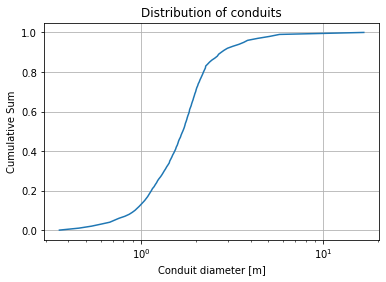

In [5]:
plt.plot(diam,quantile)
plt.xscale('log')
plt.xlabel('Conduit diameter [m]')
plt.ylabel('Cumulative Sum')
plt.title('Distribution of conduits')
plt.grid()
plt.show()

## Define the functions

In [6]:
g = 9.81 # Acceleration of gravity [m/s2]

def f_karman(Rr):
    """ 
    Computes the friction factor for a given rugosity assuming that 
    the Reynolds number is very large
    """
    return 1/(2*np.log10(Rr/3.7))**2


def flux_from_cavity(h,d,L,Rr,verbose=False,rho=998,mu=1.3e-3, cs = 0.5):
    """ 
    Computes the flux from a cavity through a karst conduit to a tunnel 
    using Bernoulli and Darcy-Weisbach equations
    
    input:
    
     h = height of the water level in cavity above the tunnel in [m]
     d = diameter of the conduits in [m]
     L = length of the horizontal condtuit in [m]
     Rr = rugosity of the conduits [unitless ratio] (should be < 0.1)
     
     verbose = a boolean flag, if equals True it prints intermediate results
     rho, mu = density and viscosity
     cs = singular head losses (by default only entrance into conduit)
    
    output:
    
     q = flux in [m3/s]
     
    method:
     a non linear equation solver is used 
     
     two coupled equations are considered
     - one coming from Bernoulli energy balance and Darcy Weisbach
     - the Colenbrook equation to determine the friction factor 
     
     the non linear solver needs an initial solution, therefore solving 
     the problems requires two steps:
      1/ we get an approximate solution assuming that reynolds numbers is very high
      2/ we use this as a starting point for the non linear solver
    
    """    
    
    # Compute approximate solution
    f = f_karman(Rr) # friction factor for high Reynolds number (Karman equation)
    v = np.sqrt( 2*g*h / (1 + cs + f*L/d) ) # Solving Bernoulli for velocity
    
    # Define the system of non linear equations to solve
    def flowproblem(x):
        """
        Takes as an input the two unknowns:
         x[0] is the velocity, and x[1] the friction factor
         
        Returns the values computed for the two equations to solve. These values
        should be equal to zero.
        """
        
        # This is just to improve readibility 
        v,f = x[0], x[1] # flow velocity [m/s] and friction factor
        
        # Initialize the values returned by the function
        y = np.zeros(2)

        # Bernoulli equation: y[0] should be equal to 0 to ensure energy balance
        y[0] = v**2 * (1+ cs + f*L/d)  - 2*g*h
        
        # Colebrook equation written as a function of f and v
        # The Reynolds number is written explicitly
        y[1] = 1/np.sqrt(f) + 2*np.log10(Rr/3.7 + 2.51*mu/(v*rho*d*np.sqrt(f)))
 
        return y
    
    # Solve the non linear problem
    x = fsolve( flowproblem, [v,f] )
    v,f = x[0], x[1]
    
    # Compute the flux in [m3/s]
    q = np.pi * (d/2)**2 * v
    
    # To print detailed results
    if verbose:
        y = flowproblem(x) # For convergence check
        print('input:')
        print('------')
        print(' total height:',h,'[m]')
        print(' diameter:',d,'[m]')
        print(' length:',L,'[m]')
        print(' rugosity:',Rr,'[unitless]')
        print(' mu/rho:',mu/rho,'[m2*s]')
        print(' cs:',cs,'[-]')
        print('output:')
        print('-------')
        print(' velocity:',v,'[m/s]')
        print(' flux:',q,'[m3/s]')
        print(' friction factor:',f,'[unitless]')
        print(' Reynolds number:',v*rho*d/mu,'[unitless]')
        print('convergence check:')
        print('-------')
        print(' Bernoulli equation:',y[0])
        print(' Colenbrook equation:',y[1])
    
    return q

def conduit_diameter(n=1):
    '''
    Get a conduit diameter array randomly draw from the  pipe distribution
    '''
    rand = np.random.random(n)
    pipe_area = pipe_function(rand)
    pipe_diameter = 2 * np.sqrt(pipe_area/math.pi)
    return pipe_diameter

## MonteCarlo diameter distribution

In [24]:
#define parameters for the simulation
n_sim              = 10000
conduit_max_length = 20
Rugosity           = [0.02,0.2]
cave_pressures     = [2,5,10,20] 

q_store = []
b_store = []
pipe_l          = np.random.random((n_sim,len(cave_pressures))) * conduit_max_length

breach_diameter = conduit_diameter((n_sim,len(cave_pressures)))              #breach from distribution
#breach_diameter = np.random.random((n_sim,len(cave_pressures))) * 2 + 0.01  #breach from uniform distribution

Rugosity        = np.random.random((n_sim,len(cave_pressures))) * (Rugosity[1]-Rugosity[0]) + Rugosity[0]
Q_out           = np.empty((n_sim,len(cave_pressures)))

for cave_pressure,it in zip(cave_pressures,range(len(cave_pressures))):
    cave_max_height = cave_pressure * 10.197162
    cave_height     = np.ones(n_sim) * cave_max_height
    
    for h,d,L,Rr,i in zip(cave_height,breach_diameter[:,it],pipe_l[:,it],Rugosity[:,it],range(n_sim)):
        Q_out[i,it] = flux_from_cavity(h,d,L,Rr,verbose=False,rho=998,mu=1.3e-3, cs = 0.5)
        
    q_store.append(Q_out)
    b_store.append(breach_diameter)

In [25]:
np.savetxt('mc_flux.txt', np.array(Q_out))
np.savetxt('mc_breach.txt', np.array(breach_diameter))

In [ ]:
fontsize=24
path_save_fig = 'images/bases_cases.png'

#Pipe vs flow
plt.figure(figsize=(14,10))
for i in range(pipe_l.shape[1]):
    plt.scatter(Q_out[:,i]*1000, np.pi*(breach_diameter[:,i]/2)**2, s=20, edgecolor='black', zorder=3, linewidth=0.4,color=color_pall[2][i])
    plt.xscale('log')
    plt.yscale('log')
    
#plt.title("Flux over 10'000 iterations")
plt.xlabel('Flow [l/s]',fontsize=fontsize)
plt.ylabel('Karst Conduit section [m²]',fontsize=fontsize)

plt.grid(b=True, which='minor', c='lightgrey')
plt.tick_params(labelsize=20)
lgnd = plt.legend(['P = 2 bar','P = 5 bar', 'P = 10 bar','P = 20 bar'],fontsize=fontsize,loc='upper left') #to adjust from the define pressure

lgnd.legendHandles[0]._sizes = [80]
lgnd.legendHandles[1]._sizes = [80]
lgnd.legendHandles[2]._sizes = [80]
lgnd.legendHandles[3]._sizes = [80]

plt.grid(color='lightgrey')
plt.title('Exemple distribution',fontsize=fontsize)
plt.savefig(path_save_fig)
plt.show()

In [27]:
import statistics as stats
statistiques = []
for i in range(4):
    minD = np.min(Q_out[:,i]*1000)
    meanD= np.mean(Q_out[:,i]*1000)
    modeD= np.median(Q_out[:,i]*1000,)
    maxD = np.max(Q_out[:,i]*1000)
    print('*****************')
    print('Min value is {} [l/s)]'.format(minD))
    print('Mean value is {} [l/s)]'.format(meanD))
    print('Median value is {} [l/s)]'.format(modeD))
    print('Max value is {} [l/s)]'.format(maxD))
    statistiques.append([minD,meanD,maxD])

*****************
Min value is 736.8516343697519 [l/s)]
Mean value is 65254.0647337843 [l/s)]
Median value is 31023.64285868357 [l/s)]
Max value is 3557816.8068848797 [l/s)]
*****************
Min value is 1219.1368007904707 [l/s)]
Mean value is 99548.4058730172 [l/s)]
Median value is 50244.054187066984 [l/s)]
Max value is 5463188.490607463 [l/s)]
*****************
Min value is 1566.397911449564 [l/s)]
Mean value is 141069.45557771355 [l/s)]
Median value is 69142.30468014427 [l/s)]
Max value is 7886966.949452899 [l/s)]
*****************
Min value is 2375.0844140388913 [l/s)]
Mean value is 197506.74262873677 [l/s)]
Median value is 99380.41371495105 [l/s)]
Max value is 11116241.509098943 [l/s)]


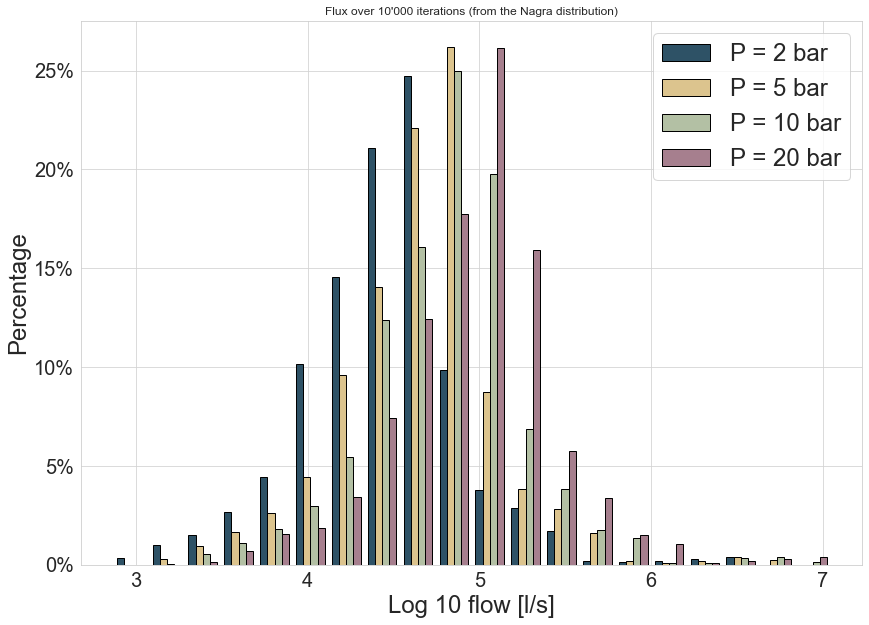

In [28]:
#histogramme flux
path_save_fig = 'flux_distribution.png'

plt.figure(figsize=(14,10))
plt.hist(np.log10(Q_out*1000),weights=np.ones(Q_out.shape)/Q_out.shape[0],  bins = 20, edgecolor='black', color=color_pall[3-1][0:4], rwidth=0.8
         ,zorder=3)

plt.title("Flux over 10'000 iterations (from the distribution)")
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1,decimals=0))
plt.tick_params(labelsize=20)
plt.xlabel('Log 10 flow [l/s]',fontsize=fontsize)
plt.ylabel('Percentage',fontsize=fontsize)
plt.grid( which='major', c='lightgrey')
plt.legend(['P = 2 bar','P = 5 bar', 'P = 10 bar','P = 20 bar'],fontsize=fontsize)
plt.savefig(path_save_fig)
plt.show()

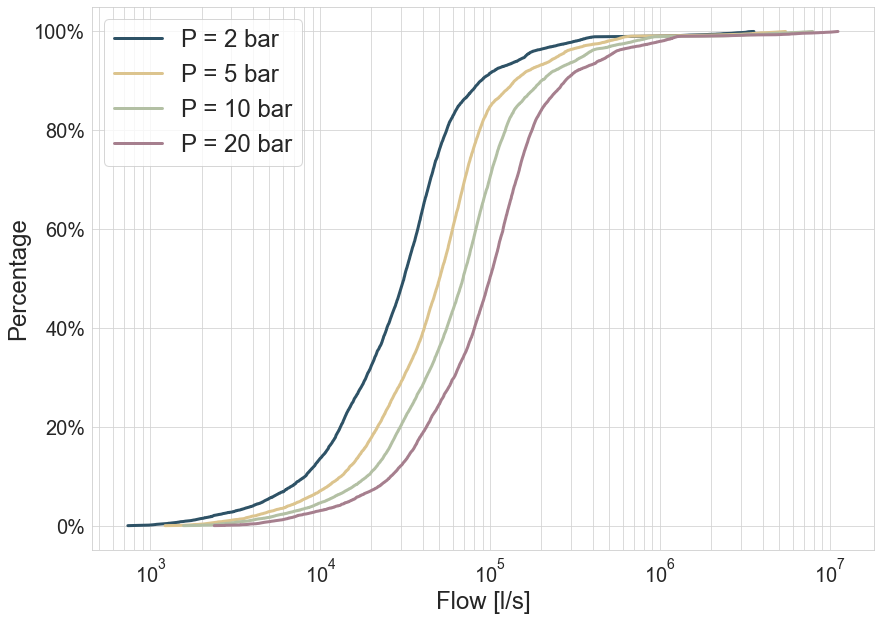

In [29]:
fontsize = 24
path_save_fig = 'flux_cum_distribution.png'

#histogramme flux
plt.figure(figsize=(14,10))
for i in range(4):
    data = Q_out[:,i]*1000
    data = np.sort(data)
    p = 1. * np.arange(len(data)) / (len(data) - 1)
    plt.plot(data,p,color=color_pall_3[i], zorder=3,linewidth=3)
    
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1,decimals=0))
plt.tick_params(labelsize=20)
plt.xscale('log')
plt.xlabel('Flow [l/s]',fontsize=fontsize)
plt.ylabel('Percentage',fontsize=fontsize)
plt.grid( which='both', c='lightgrey')
plt.legend(['P = 2 bar','P = 5 bar', 'P = 10 bar','P = 20 bar'],fontsize=fontsize)
plt.savefig(path_save_fig)
plt.show()

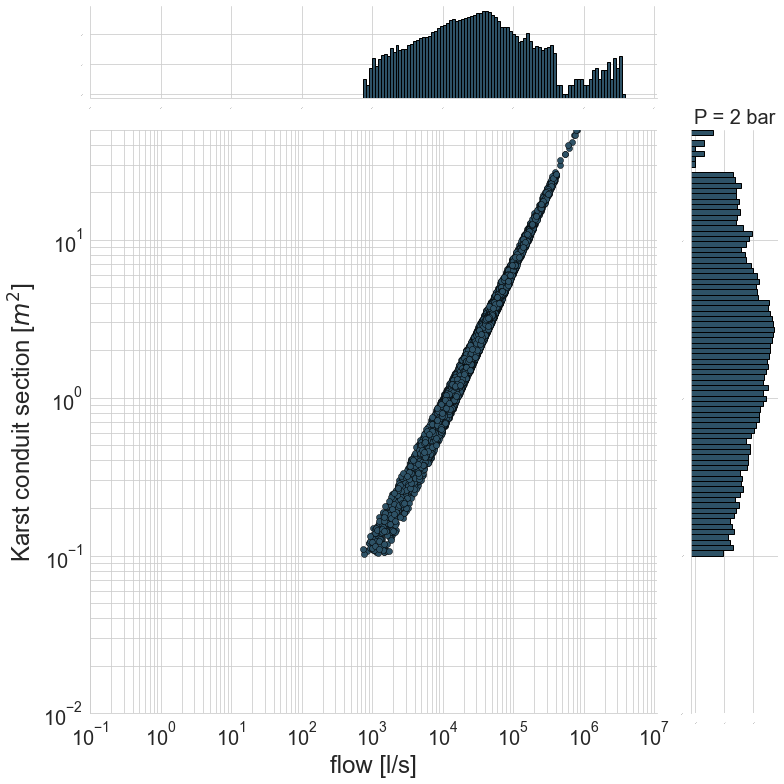

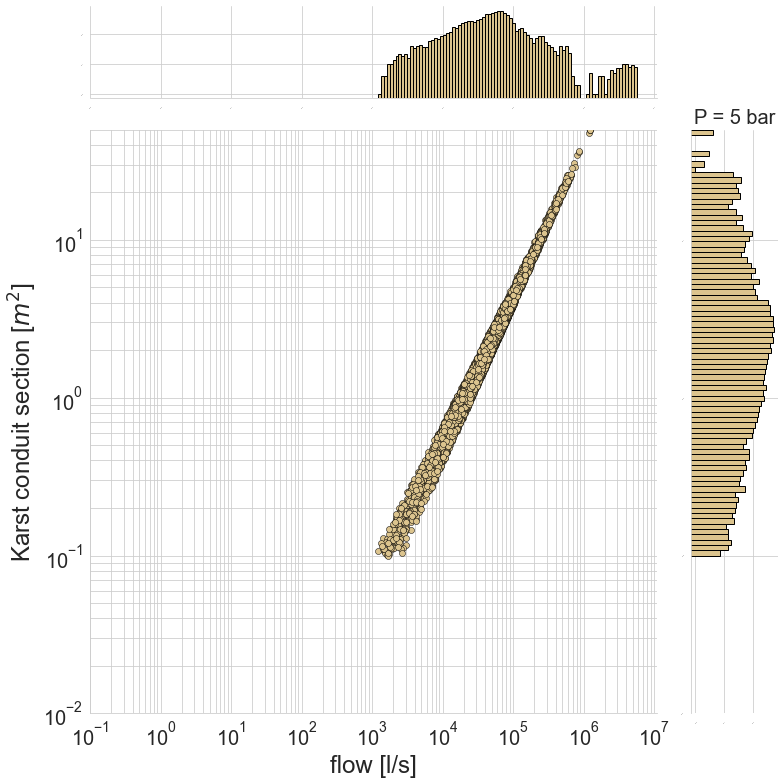

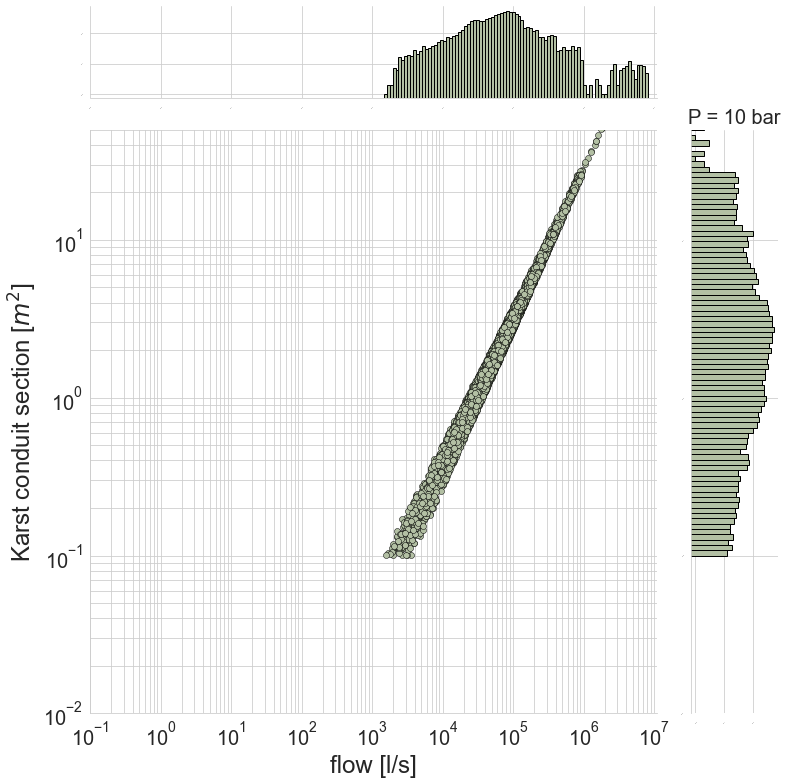

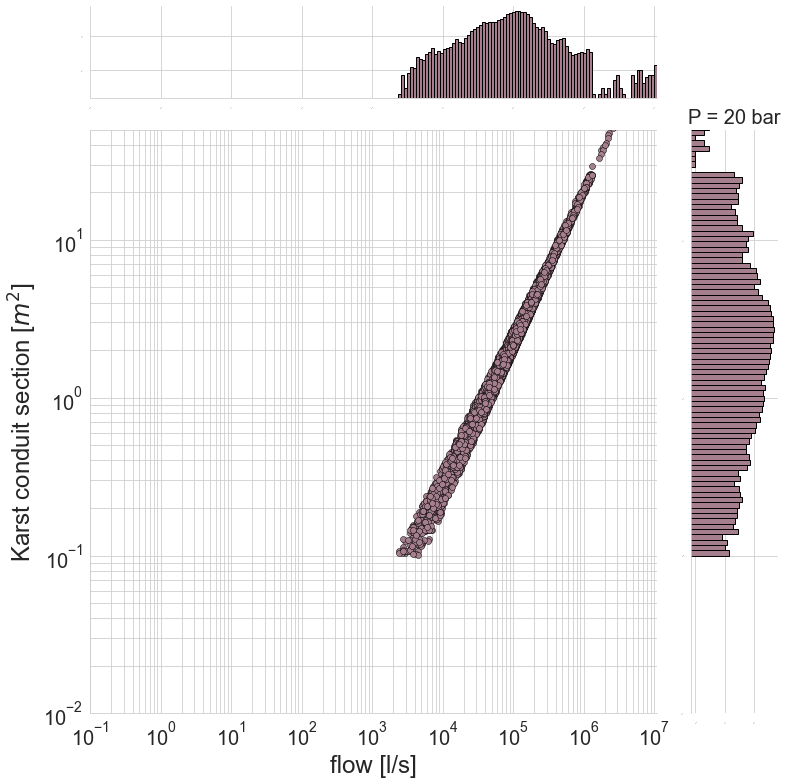

In [30]:
sns.set_style("whitegrid")
path_save_fig = '../../../98_images/00_cave/02_darcy_w/'

mybins_x =np.logspace(np.log10(np.nanmin(Q_out[:]*1000)),np.log10(np.nanmax(Q_out[:]*1000)),100)
mybins_y =np.logspace(np.log10(np.nanmin((np.pi * np.power(breach_diameter[:]/2,2)))),np.log10(np.nanmax((np.pi * np.power(breach_diameter[:]/2,2)))),100)

for i in range(4):
    h = sns.jointplot(y=(np.pi * np.power(breach_diameter[:,i]/2,2)),x=(Q_out[:,i]*1000),height=11,color=color_pall[2][i],edgecolor='k')
    # JointGrid has a convenience function
    h.ax_marg_x.clear()
    h.ax_marg_y.clear()
    
    h.ax_marg_x.hist((Q_out[:,i]*1000),log=True,bins=mybins_x,color=color_pall[2][i],edgecolor='k')
    h.ax_marg_y.hist((np.pi * np.power(breach_diameter[:,i]/2,2)),log=True,bins=mybins_y,orientation='horizontal',color=color_pall[2][i],edgecolor='k')

    h.set_axis_labels( 'flow [l/s]', 'Karst conduit section [$m^2$]', fontsize=24)
    h.ax_joint.tick_params(labelsize=20)
    ax = h.ax_joint
    ax.set_xscale('log')
    ax.set_yscale('log')
    h.ax_marg_x.set_xscale('log')
    h.ax_marg_y.set_yscale('log')
   
    h.ax_marg_x.tick_params(axis='both', labelsize=0.01)
    h.ax_marg_y.tick_params(axis='both', labelsize=0.01)
    
    ax.set_xlim(0.1,np.nanmax(Q_out[:]*1000))
    ax.set_ylim(0.01,50)
    ax.grid(True,'both','both')
   # h.ax_marg_y.set_ylim(0.01,100)
   #h.ax_marg_x.set_xlim(1,np.nanmax(Q_out[:]*1000))

    plt.title('P = '+ str(cave_pressures[i])  + ' bar',size = 20)
    plt.tight_layout()
    plt.savefig(path_save_fig+'KDE_distribution_'+str(cave_pressures[i])+'bar_log.png')

## MonteCarlo Uniforme distribution

In [31]:
#define parameter for the simulation
n_sim              = 10000
conduit_max_length = 20
Rugosity           = [0.02,0.2]
cave_pressures     = [2,5,10,20] 

q_store = []
b_store = []
pipe_l          = np.random.random((n_sim,len(cave_pressures))) * conduit_max_length

#breach_diameter = conduit_diameter((n_sim,len(cave_pressures)))              #breach from distribution
breach_diameter = np.random.random((n_sim,len(cave_pressures))) * 2 + 0.01  #breach from uniform distribution


Rugosity        = np.random.random((n_sim,len(cave_pressures))) * (Rugosity[1]-Rugosity[0]) + Rugosity[0]
Q_out           = np.empty((n_sim,len(cave_pressures)))

for cave_pressure,it in zip(cave_pressures,range(len(cave_pressures))):
    cave_max_height = cave_pressure * 10.197162
    cave_height     = np.ones(n_sim) * cave_max_height
    
    for h,d,L,Rr,i in zip(cave_height,breach_diameter[:,it],pipe_l[:,it],Rugosity[:,it],range(n_sim)):
        Q_out[i,it] = flux_from_cavity(h,d,L,Rr,verbose=False,rho=998,mu=1.3e-3, cs = 0.5)
        
    q_store.append(Q_out)
    b_store.append(breach_diameter)

In [32]:
np.savetxt('mc_flux_uni.txt', np.array(Q_out))
np.savetxt('mc_breach_uni.txt', np.array(breach_diameter))

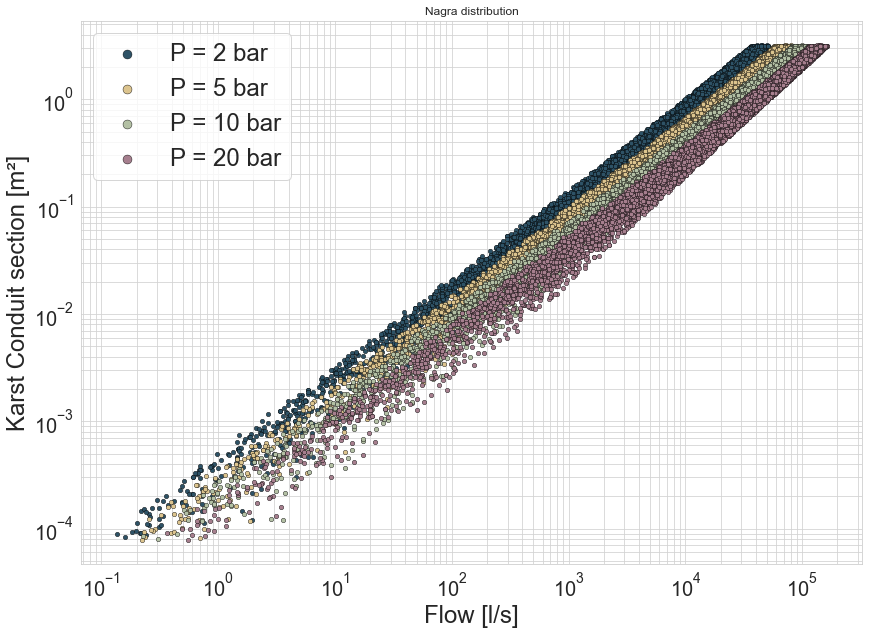

In [33]:
fontsize=24
path_save_fig = '../../../98_images/00_cave/02_darcy_w/Base_case_uni_distribution.png'

#Pipe vs flow
plt.figure(figsize=(14,10))
for i in range(pipe_l.shape[1]):
    plt.scatter(Q_out[:,i]*1000, np.pi*(breach_diameter[:,i]/2)**2, s=20, edgecolor='black', zorder=3, linewidth=0.4,color=color_pall[2][i])
    plt.xscale('log')
    plt.yscale('log')
    
#plt.title("Flux over 10'000 iterations")
plt.xlabel('Flow [l/s]',fontsize=fontsize)
plt.ylabel('Karst Conduit section [m²]',fontsize=fontsize)

plt.grid(b=True, which='minor', c='lightgrey')
plt.tick_params(labelsize=20)
lgnd = plt.legend(['P = 2 bar','P = 5 bar', 'P = 10 bar','P = 20 bar'],fontsize=fontsize,loc='upper left') #to adjust from the define pressure

lgnd.legendHandles[0]._sizes = [80]
lgnd.legendHandles[1]._sizes = [80]
lgnd.legendHandles[2]._sizes = [80]
lgnd.legendHandles[3]._sizes = [80]

plt.grid(color='lightgrey')
plt.savefig(path_save_fig)
plt.show()

In [34]:
import statistics as stats
statistiques = []
for i in range(4):
    minD = np.min(Q_out[:,i]*1000)
    meanD= np.mean(Q_out[:,i]*1000)
    modeD= np.median(Q_out[:,i]*1000,)
    maxD = np.max(Q_out[:,i]*1000)
    print('*****************')
    print('Min value is {} [l/s)]'.format(minD))
    print('Mean value is {} [l/s)]'.format(meanD))
    print('Median value is {} [l/s)]'.format(modeD))
    print('Max value is {} [l/s)]'.format(maxD))
    statistiques.append([minD,meanD,maxD])

*****************
Min value is 0.1348502947980985 [l/s)]
Mean value is 14244.424157191652 [l/s)]
Median value is 10045.241079914587 [l/s)]
Max value is 51177.62625777339 [l/s)]
*****************
Min value is 0.22411160264901928 [l/s)]
Mean value is 22742.651577724402 [l/s)]
Median value is 16133.854987231049 [l/s)]
Max value is 80978.73692421574 [l/s)]
*****************
Min value is 0.22911605909587338 [l/s)]
Mean value is 31999.644630676063 [l/s)]
Median value is 22415.462270024487 [l/s)]
Max value is 115084.71936999391 [l/s)]
*****************
Min value is 0.3644261240008072 [l/s)]
Mean value is 45907.78045839571 [l/s)]
Median value is 33560.84736945479 [l/s)]
Max value is 162607.25355491004 [l/s)]


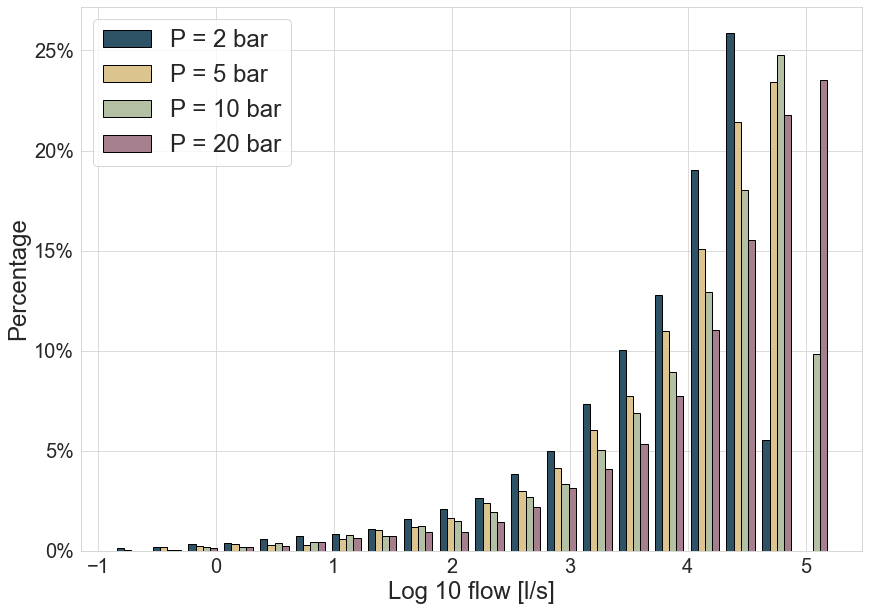

In [35]:
#histogramme flux
path_save_fig = '../../../98_images/00_cave/02_darcy_w/flux_distribution_uni_distribution.png'

plt.figure(figsize=(14,10))
plt.hist(np.log10(Q_out*1000),weights=np.ones(Q_out.shape)/Q_out.shape[0],  bins = 20, edgecolor='black', color=color_pall[3-1][0:4], rwidth=0.8
         ,zorder=3)

plt.gca().yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1,decimals=0))
plt.tick_params(labelsize=20)
plt.xlabel('Log 10 flow [l/s]',fontsize=fontsize)
plt.ylabel('Percentage',fontsize=fontsize)
plt.grid( which='major', c='lightgrey')
plt.legend(['P = 2 bar','P = 5 bar', 'P = 10 bar','P = 20 bar'],fontsize=fontsize)
plt.savefig(path_save_fig)
plt.show()

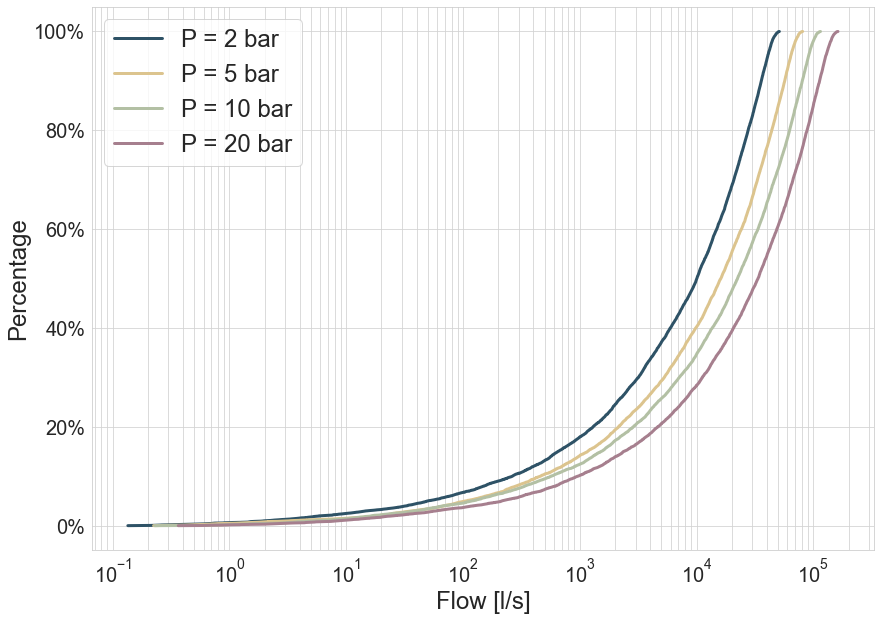

In [36]:
fontsize = 24
path_save_fig = '../../../98_images/00_cave/02_darcy_w/flux_cum_uni_distribution.png'

#histogramme flux
plt.figure(figsize=(14,10))
for i in range(4):
    data = Q_out[:,i]*1000
    data = np.sort(data)
    p = 1. * np.arange(len(data)) / (len(data) - 1)
    plt.plot(data,p,color=color_pall_3[i], zorder=3,linewidth=3)

plt.gca().yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1,decimals=0))
plt.tick_params(labelsize=20)
plt.xscale('log')
plt.xlabel('Flow [l/s]',fontsize=fontsize)
plt.ylabel('Percentage',fontsize=fontsize)
plt.grid( which='both', c='lightgrey')
plt.legend(['P = 2 bar','P = 5 bar', 'P = 10 bar','P = 20 bar'],fontsize=fontsize)
plt.savefig(path_save_fig)
plt.show()

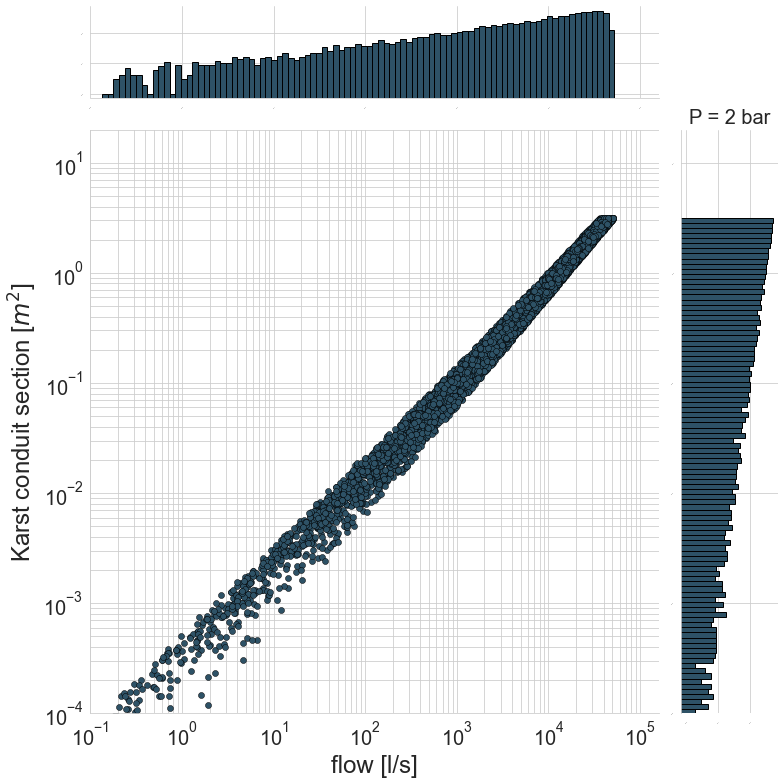

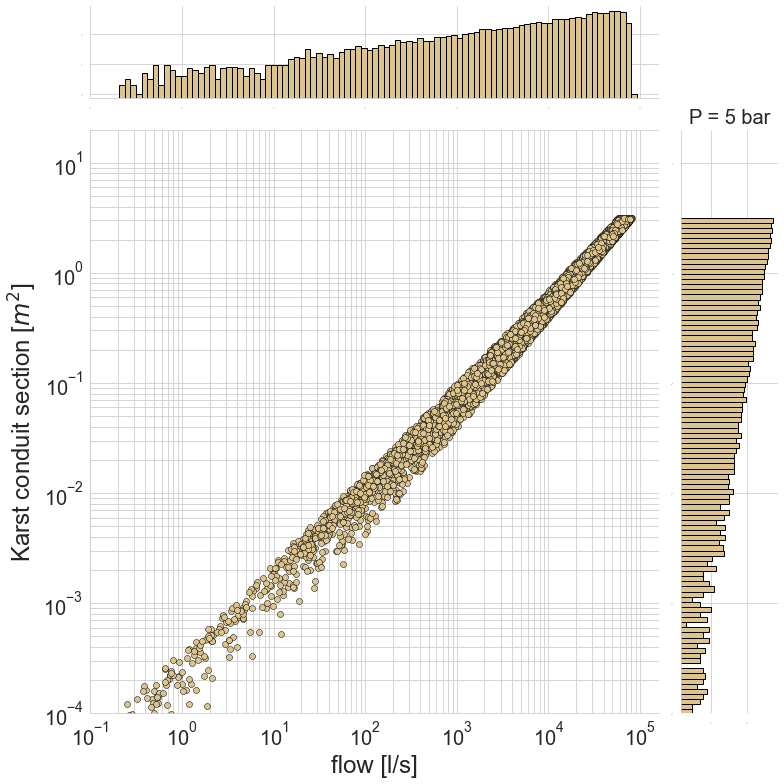

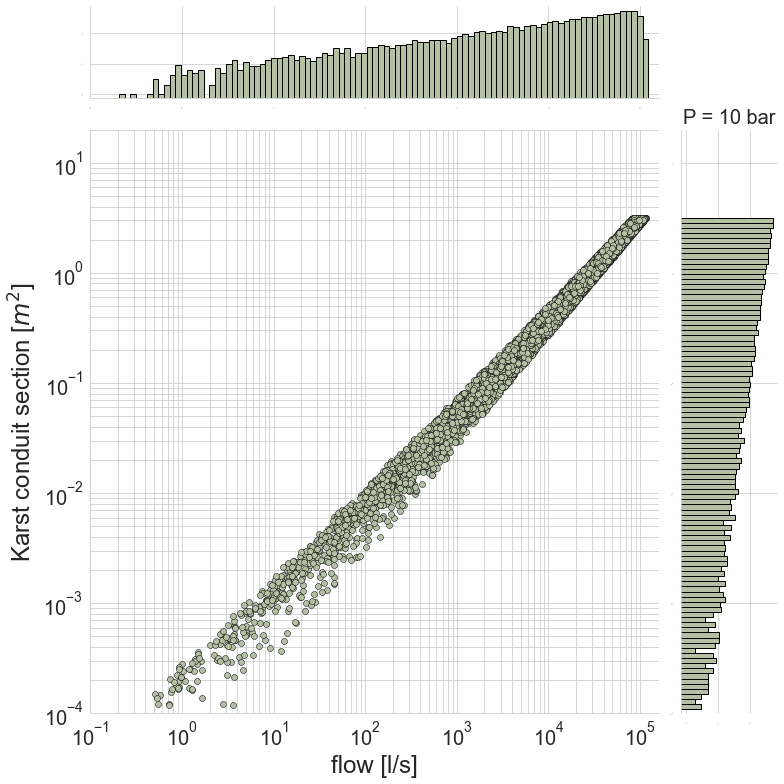

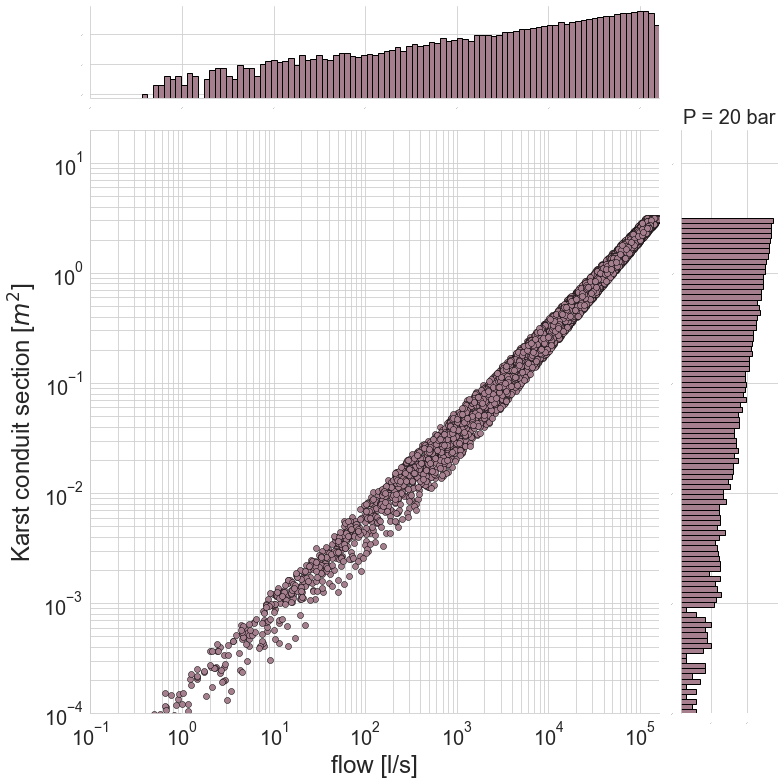

In [37]:
sns.set_style("whitegrid")

path_save_fig = '../../../98_images/00_cave/02_darcy_w/'

mybins_x =np.logspace(np.log10(np.nanmin(Q_out[:]*1000)),np.log10(np.nanmax(Q_out[:]*1000)),100)
mybins_y =np.logspace(np.log10(np.nanmin((np.pi * np.power(breach_diameter[:]/2,2)))),np.log10(np.nanmax((np.pi * np.power(breach_diameter[:]/2,2)))),100)

for i in range(4):
    h = sns.jointplot(y=(np.pi * np.power(breach_diameter[:,i]/2,2)),x=(Q_out[:,i]*1000),height=11,color=color_pall[2][i],edgecolor='k')
    # JointGrid has a convenience function
    h.ax_marg_x.clear()
    h.ax_marg_y.clear()
    
    h.ax_marg_x.hist((Q_out[:,i]*1000),log=True,bins=mybins_x,color=color_pall[2][i],edgecolor='k')
    h.ax_marg_y.hist((np.pi * np.power(breach_diameter[:,i]/2,2)),log=True,bins=mybins_y,orientation='horizontal',color=color_pall[2][i],edgecolor='k')

    h.set_axis_labels( 'flow [l/s]', 'Karst conduit section [$m^2$]', fontsize=24)
    h.ax_joint.tick_params(labelsize=20)
    ax = h.ax_joint
    ax.set_xscale('log')
    ax.set_yscale('log')
    h.ax_marg_x.set_xscale('log')
    h.ax_marg_y.set_yscale('log')
   
    h.ax_marg_x.tick_params(axis='both', labelsize=0.01)
    h.ax_marg_y.tick_params(axis='both', labelsize=0.01)
    
    ax.set_xlim(0.1,np.nanmax(Q_out[:]*1000))
    ax.set_ylim(0.0001,20)
    ax.grid(True,'both','both')
   # h.ax_marg_y.set_ylim(0.01,100)
   #h.ax_marg_x.set_xlim(1,np.nanmax(Q_out[:]*1000))

    plt.title('P = '+ str(cave_pressures[i])  + ' bar',size = 20)
    plt.tight_layout()
    plt.savefig(path_save_fig+'KDE_uni_distribution_'+str(cave_pressures[i])+'bar_log.png')

## Transient application

In [38]:
#define some parameters for the transient application
iterr        = 10000 #max number of iterations
dt           = 0.1   #time step
cave_section = 20*20 #section of the cave

n_sim              = 1
conduit_max_length = 20
Rugosity_b         = [0.02,0.2]
cave_pressure      = 2

pipe_l          = np.random.random((n_sim,1)) * conduit_max_length

#Diameters can either be random of fixed:
#random
breach_diameter     = conduit_diameter((n_sim,1))
#fixed
#fixed_breach_diam  = 0.1
#breach_diameter[:] = np.ones((n_sim,1))*fixed_breach_diam

In [39]:
Rugosity        = np.random.random((n_sim,1)) * (Rugosity_b[1]-Rugosity_b[0]) + Rugosity_b[0]
Q_out           = np.zeros((n_sim,iterr))

cave_max_height = cave_pressure * 10.197162
cave_height     = np.ones(n_sim) * cave_max_height

for h,d,L,Rr,i in zip(cave_height,breach_diameter,pipe_l,Rugosity,range(n_sim)):
    for it in np.arange(0, iterr):
        Q_out[i,it] = flux_from_cavity(h,d,L,Rr,verbose=False,rho=998,mu=1.3e-3, cs = 0.5)
        DHdt = Q_out[i,it] / cave_section
        Dh = DHdt * dt
        h = h-Dh
        if h < 0.1:
            break
        
pipe_l          = np.random.random((n_sim,1)) * conduit_max_length
breach_diameter = conduit_diameter((n_sim,1))
breach_diameter[:] = 0.5
Rugosity        = np.random.random((n_sim,1)) * (Rugosity_b[1]-Rugosity_b[0]) + Rugosity_b[0]
Q_out1           = np.zeros((n_sim,iterr))

cave_max_height = cave_pressure * 10.197162
cave_height     = np.ones(n_sim) * cave_max_height

for h,d,L,Rr,i in zip(cave_height,breach_diameter,pipe_l,Rugosity,range(n_sim)):
    for it in np.arange(0, iterr):
        Q_out1[i,it] = flux_from_cavity(h,d,L,Rr,verbose=False,rho=998,mu=1.3e-3, cs = 0.5)
        DHdt = Q_out1[i,it] / cave_section
        Dh = DHdt * dt
        h = h-Dh
        if h < 0.1:
            break
        
pipe_l          = np.random.random((n_sim,1)) * conduit_max_length
breach_diameter = conduit_diameter((n_sim,1))
breach_diameter[:] = 1
Rugosity        = np.random.random((n_sim,1)) * (Rugosity_b[1]-Rugosity_b[0]) + Rugosity_b[0]
Q_out2           = np.zeros((n_sim,iterr))

cave_max_height = cave_pressure * 10.197162
cave_height     = np.ones(n_sim) * cave_max_height

for h,d,L,Rr,i in zip(cave_height,breach_diameter,pipe_l,Rugosity,range(n_sim)):
    for it in np.arange(0, iterr):
        Q_out2[i,it] = flux_from_cavity(h,d,L,Rr,verbose=False,rho=998,mu=1.3e-3, cs = 0.5)
        DHdt = Q_out2[i,it] / cave_section
        Dh = DHdt * dt
        h = h-Dh
        if h < 0.1:
            break
        
cave_section = 20*20
conduit_max_length = 20
Rugosity = [0.02,0.2]
cave_pressure = 2
q_store = []
b_store = []
pipe_l          = np.random.random((n_sim,1)) * conduit_max_length
breach_diameter = conduit_diameter((n_sim,1))
breach_diameter[:] = 5
Rugosity        = np.random.random((n_sim,1)) * (Rugosity_b[1]-Rugosity_b[0]) + Rugosity_b[0]
Q_out3           = np.zeros((n_sim,iterr))

cave_max_height = cave_pressure * 10.197162
cave_height     = np.ones(n_sim) * cave_max_height

for h,d,L,Rr,i in zip(cave_height,breach_diameter,pipe_l,Rugosity,range(n_sim)):
    for it in np.arange(0, iterr):
        Q_out3[i,it] = flux_from_cavity(h,d,L,Rr,verbose=False,rho=998,mu=1.3e-3, cs = 0.5)
        DHdt = Q_out3[i,it] / cave_section
        Dh = DHdt * dt
        h = h-Dh
        if h < 0.1:
            break
        
pipe_l          = np.random.random((n_sim,1)) * conduit_max_length
breach_diameter = conduit_diameter((n_sim,1))
breach_diameter[:] = 10
Rugosity        = np.random.random((n_sim,1)) * (Rugosity_b[1]-Rugosity_b[0]) + Rugosity_b[0]
Q_out4           = np.zeros((n_sim,iterr))

cave_max_height = cave_pressure * 10.197162
cave_height     = np.ones(n_sim) * cave_max_height

for h,d,L,Rr,i in zip(cave_height,breach_diameter,pipe_l,Rugosity,range(n_sim)):
    for it in np.arange(0, iterr):
        Q_out4[i,it] = flux_from_cavity(h,d,L,Rr,verbose=False,rho=998,mu=1.3e-3, cs = 0.5)
        DHdt = Q_out4[i,it] / cave_section
        Dh = DHdt * dt
        h = h-Dh
        if h < 0.1:
            break
        
t_vector = np.arange(0,iterr*dt,dt)

In [40]:
#check the parameter for convergence
dt * DHdt

0.022157085387293208

In [41]:
c_0 = [151, 157, 172]
c_1 = [92, 103, 125]
c_2 = [4, 102, 200]
c_3 = [2, 62, 125]
c_4 = [46, 82, 102]
c_5 = [0, 18, 51]
color_degr = [c_0, c_1, c_2, c_3, c_4, c_5]
color_degr = [[idc/255 for idc in col] for col in color_degr]

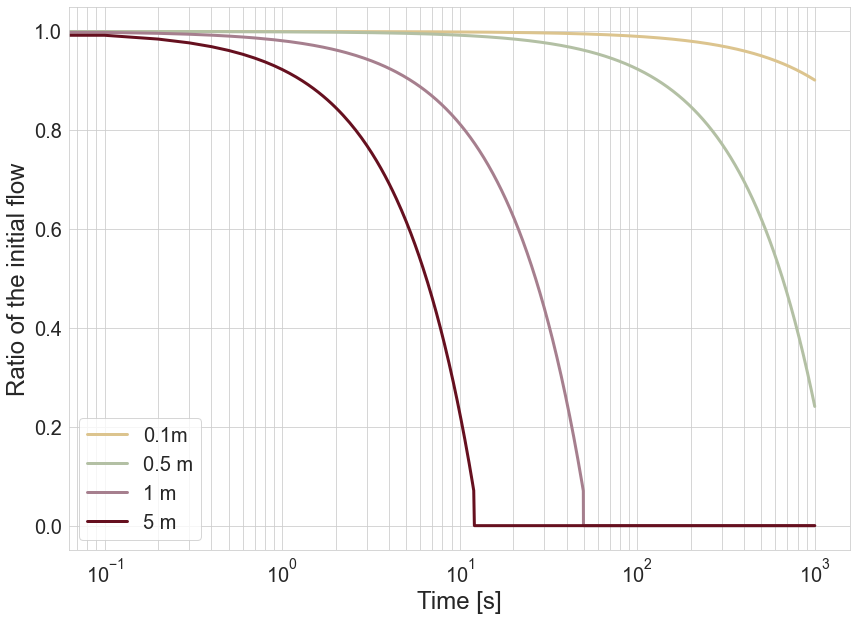

In [43]:
sns.set_style(None)

path_save_fig = '../../../98_images/00_cave/02_darcy_w/transient_darcy_w.png'

plt.figure(figsize=(14,10))

#plt.plot(t_vector,(np.mean(Q_out,axis=0)/np.mean(Q_out,axis=0)[0]),linewidth=3,color=color_degr[0])
plt.plot(t_vector,(np.mean(Q_out1,axis=0)/np.mean(Q_out1,axis=0)[0]),linewidth=3,color=color_pall[3-1][1])
plt.plot(t_vector,(np.mean(Q_out2,axis=0)/np.mean(Q_out2,axis=0)[0]),linewidth=3,color=color_pall[3-1][2])
plt.plot(t_vector,(np.mean(Q_out3,axis=0)/np.mean(Q_out3,axis=0)[0]),linewidth=3,color=color_pall[3-1][3])
plt.plot(t_vector,(np.mean(Q_out4,axis=0)/np.mean(Q_out4,axis=0)[0]),linewidth=3,color=color_pall[3-1][4])

plt.tick_params(labelsize=20)
plt.ylabel('Ratio of the initial flow',size=24)
plt.xlabel('Time [s]',size=24)

#plt.yscale('log')
plt.xscale('log')
plt.grid('on', 'both')
plt.legend([ '0.1m','0.5 m', '1 m', '5 m', '10 m'],fontsize=20)
plt.savefig(path_save_fig)

## Old figures (no used)

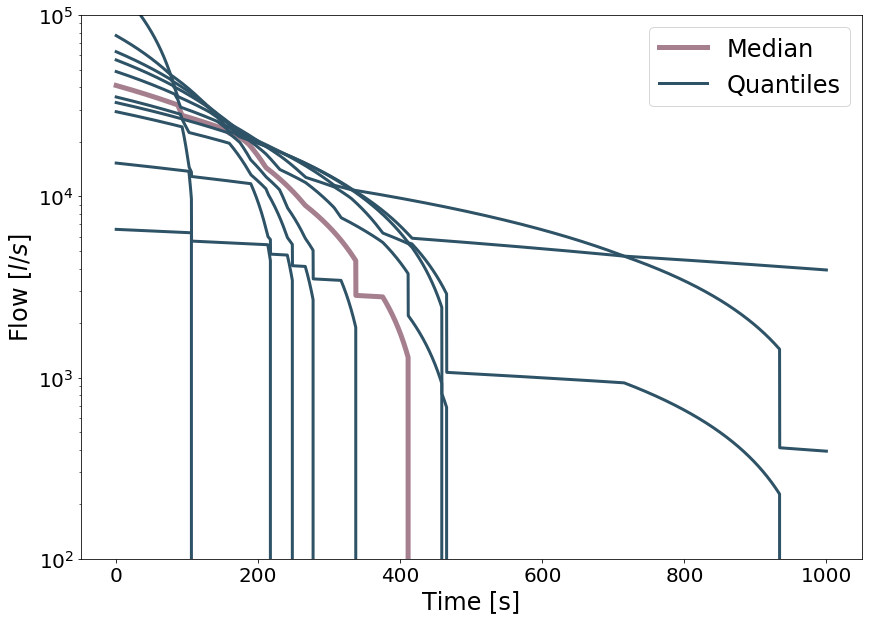

In [26]:
plt.figure(figsize=(14,10))
plt.tick_params(labelsize=20)
Q40 = np.quantile(Q_out*1000,0.5,axis=0)
#plt.plot(t_vector,Mean_Q,color=color_pall[2][0])
plt.plot(t_vector,Q40,color=color_pall[2][3],linewidth = 5)


for q in range(11):
    if q is not 5:
        Q40 = np.quantile(Q_out*1000,q/10,axis=0)

        plt.plot(t_vector,Q40,color=color_pall[2][0],linewidth = 3)


plt.ylabel('Flow [$l/s$]',size=24)
plt.xlabel('Time [s]',size=24)
plt.yscale('log')
plt.ylim(10,100000)
plt.legend(['Median', 'Quantiles'],fontsize = 24)
plt.savefig('Bernouilli_Flow_Quant.pdf')

ValueError: x and y must have same first dimension, but have shapes (5000,) and (100,)

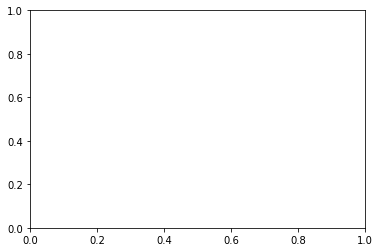

In [62]:
for i in range(10):
    plt.plot(t_vector,Q_out[:,i])

In [ ]:
it = 5000
dt = 0.1
res_Q = np.zeros((n_sim,it))
res_h = np.zeros((n_sim,it))
Bar = ProgressBar(n_sim, 60, 'Simulating in progress...')

for cave,breach,sim in zip(cave_height,breach_diameter,range(n_sim)):
    cave_section = np.power(np.random.random((1,))*cave/2,2)
    Area = math.pi * np.power(breach/2,2)
    g = 9.81
    Bar.update(sim)
    for i in np.arange(0, it):
        dQdt = Area*np.sqrt(2*g*cave)
        Q = dQdt * dt
        dh = Q/cave_section
        cave = cave-dh
        res_Q[sim][i] = dQdt
        res_h[sim][i] = cave
        if cave <= 0:
            break

        

In [45]:
n_sim = 1000
dt = 1
iterr = 600

cave_section = 20*20
conduit_max_length = 20
Rugosity = [0.02,0.2]
cave_pressure = 2
q_store = []
b_store = []
pipe_l          = np.random.random((n_sim,1)) * conduit_max_length
breach_diameter = conduit_diameter((n_sim,1))
breach_diameter[:] = 10
breach_diameter = np.random.random((n_sim,1)) * 2 + 0.01 

Rugosity        = np.random.random((n_sim,1)) * (Rugosity[1]-Rugosity[0]) + Rugosity[0]
Q_out4           = np.zeros((n_sim,iterr))

cave_max_height = cave_pressure * 10.197162
cave_height     = np.ones(n_sim) * cave_max_height

for h,d,L,Rr,i in zip(cave_height,breach_diameter,pipe_l,Rugosity,range(n_sim)):
    for it in np.arange(0, iterr):
        Q_out4[i,it] = flux_from_cavity(h,d,L,Rr,verbose=False,rho=998,mu=1.3e-3, cs = 0.5)
        DHdt = Q_out4[i,it] / cave_section
        Dh = DHdt * dt
        h = h-Dh
        if h < 0.1:
            break
        
q_store.append(Q_out)
b_store.append(breach_diameter)

t_vector = np.arange(0,iterr*dt,dt)

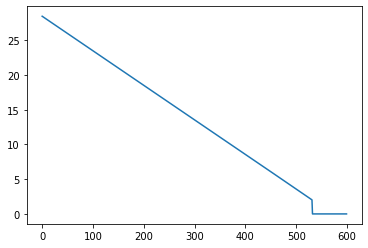

In [46]:
#breach_diameter
plt.plot(Q_out4[3,:])

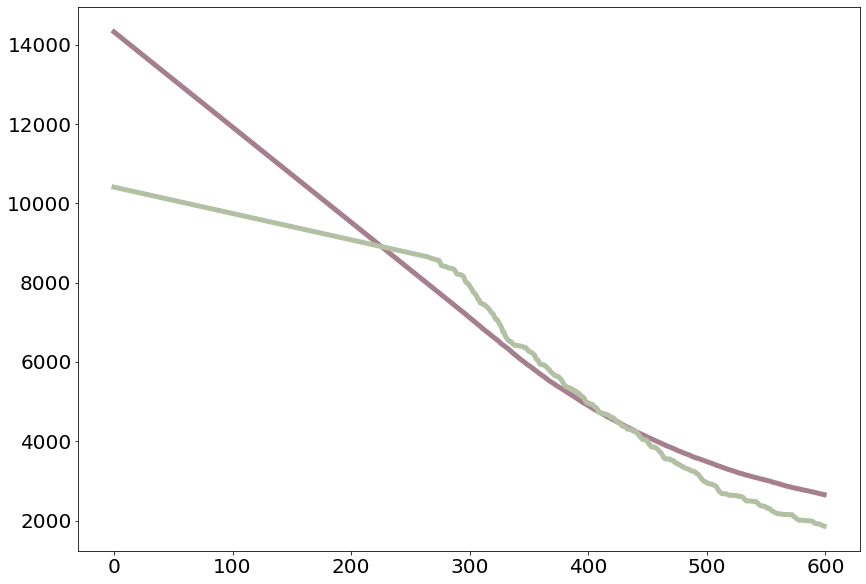

In [48]:
plt.figure(figsize=(14,10))
plt.tick_params(labelsize=20)

Q40 = np.mean(Q_out4*1000,axis=0)
Q50 = np.median(Q_out4*1000,axis=0)

#plt.plot(t_vector,Mean_Q,color=color_pall[2][0])
plt.plot(t_vector,Q40,color=color_pall[2][3],linewidth = 5)
plt.plot(t_vector,Q50,color=color_pall[2][2],linewidth = 5)